# Kohonen SOM

In this notebook we will use the classic Kohonen Self-Organizing Map (SOM) to deal with 2 basic data sets. We will show some of the functionality of the sciSOM package. We will show how to train and SOM and make a few basic plots to try to asses how well the SOM has learned from the data.
We will be using 2 test datasets for this demonstration:

- One which we will generate by getting points from 4 gaussian distribution in a 2D space. 
- The other will be the penguins dataset, which is currently being used to replace the iris dataset. This dataset coinsists of 3 classes. One fully separable from the rest and 2 classes which are note separable.

We will normalize the datasets, and examine there results. A separate notebook will be made which will be more in depth regarding the different visualizations we can use to determine the SOM clusters as well as tool to designate said clusters.

In [1]:
# Here we will import our main SOM module as well as a normalizing function
from sciSOM import SOM, affine_transform, calculate_u_matrix, plot_SOM_gird_neurons
from sciSOM import calculate_density_matrix, display_density_matrix

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

### 4 gaussian dataset setup

Lets make a simple dataset which we understand to see if the SOM exhibits the expected behaviours! We will generate a dataset with 4 classes. Each class will be centered at one of 4 points ([1,1] [1,2] [2,1] [2,2]) and we will add some gaussian noise to these coordinates to make our dataset.

In [3]:
n_samples = 2000  # Total number of samples
centers = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])  # Centers of the 4 Gaussian distributions
std_dev = 0.1  # Standard deviation of the Gaussian distributions
n_centers = len(centers)
samples_per_center = n_samples // n_centers

data = []
for center in centers:
    samples = np.random.normal(loc=center, scale=std_dev, size=(samples_per_center, 2))
    data.append(samples)

# Combine all samples into a single array
gaussian_data_4_classes = np.vstack(data)

# Lets also normalize our data
gaussian_data_4_classes_norm = affine_transform(gaussian_data_4_classes, 0, 1)

Text(0, 0.5, 'Y')

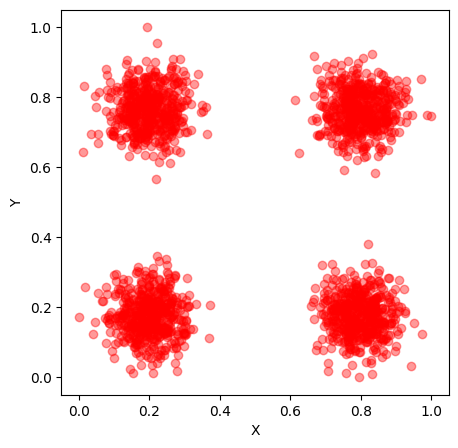

In [4]:
# Lets plot our data to see what it looks like!

plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], 
            color = 'red',
            alpha=0.4)
plt.xlabel('X')
plt.ylabel('Y')
#plt.title('Generated Gaussian Mixture Dataset')
#plt.show()

### Now lets load up the penguins dataset!

The dataset coinsists of 3 populations of penguins (Adelie, Gentoo, Chinstrap) and provides data about 4 characteristics:bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g. It also include other information such as the sex of the penguins, the island they are from and the year in which this data was recorded however these will not be used for our analysis.

In [5]:
# Import the penguins dataset
penguins_df = pd.read_csv("../../test_data/penguins.csv")

# The dataset constains many nan values, we will reject all data with nans
penguins_df = penguins_df.dropna()

In [6]:
penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [7]:
# Function to convert all elements we need into the same datatype (floats)
def convert_to_float(arr):
    # Flatten the array to handle nested objects if any
    flat_arr = arr.ravel()
    
    # Convert all elements to float
    flat_arr = [float(element) for element in flat_arr]
    
    # Reshape back to the original shape
    return np.array(flat_arr).reshape(arr.shape)

In [8]:
penguins_data= np.array((penguins_df.to_numpy()[:,2],
                    penguins_df.to_numpy()[:,3],
                    penguins_df.to_numpy()[:,4],
                    penguins_df.to_numpy()[:,5]))

In [9]:
penguins_data = convert_to_float(penguins_data)
penguins_data = np.transpose(penguins_data)

penguins_data_normalized = affine_transform(penguins_data, 0, 1)

### Now lets set up everything we need to train the SOM

In [10]:
# Make the datetype for the input parameter table
dtype = np.dtype([
    ('time', 'i8'),  
    ('alpha', 'float'),    
    ('sigma', 'float'),  
    ('max_radius', 'i8')
])

There are 2 ways to set parameters to train the SOM. 
- One of them is to set initial parameters and then use a functional decay in which these parameters are monotonically decreasing over time.
- The second way is to set up a parameter table in which the user chooses which parameters will be used at any given time. Here the user should take care that the parameters decrease or stay the same with every decay step. (might be usedful to have a check to confirm this)

In [11]:
# Make parameters to use for decay functions
parameters = np.zeros(1, dtype=dtype)

parameters[0] = (100, 0.3, 0.2, 5)

In [12]:
# Make a parameter table to decay via a set schedule
parameters_schedule = np.zeros(3, dtype=dtype)
parameters_schedule[0] = (2000, 0.3, 0.2, 5)
parameters_schedule[1] = (8000, 0.01, 0.1, 3)
parameters_schedule[2] = (40000, 0.001, 0.1, 1)

In [13]:
# Here we make an instance of the SOM class. It needs to be given the dimensions of the SOM
# As well as the dimensions of the input vectors and the number or itterations for training
# For a full explination of all parameters please see the documentation.
som_model_simple = SOM(x_dim = 7, y_dim = 7, input_dim = 2, n_iter=40000,
                   learning_parameters=parameters_schedule,
                   decay_type='schedule', mode = "online", #neighborhood_decay = "exponential"
                       save_weight_cube_history = True
                   )

In [14]:
# This is a flag that check is the SOM has been trained after you make an instance of it
som_model_simple.is_trained

False

In [15]:
# Train the SOM
som_model_simple.train(gaussian_data_4_classes_norm)

In [16]:
som_model_simple.is_trained

True

In [17]:
# shows you how often each neuron "won" over the training
som_model_simple.weight_cube_history

array([[2.349e+03, 1.500e+03, 7.860e+02, 1.900e+01, 1.207e+03, 1.319e+03,
        2.348e+03],
       [1.662e+03, 8.260e+02, 6.230e+02, 0.000e+00, 8.260e+02, 6.970e+02,
        1.438e+03],
       [1.016e+03, 6.970e+02, 3.120e+02, 0.000e+00, 4.890e+02, 8.760e+02,
        8.750e+02],
       [1.200e+01, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 7.000e+00,
        0.000e+00],
       [1.205e+03, 7.600e+02, 3.350e+02, 0.000e+00, 3.790e+02, 6.480e+02,
        9.040e+02],
       [1.276e+03, 8.470e+02, 6.310e+02, 2.600e+01, 8.340e+02, 8.820e+02,
        1.522e+03],
       [2.467e+03, 1.565e+03, 9.650e+02, 0.000e+00, 1.128e+03, 1.255e+03,
        2.486e+03]])

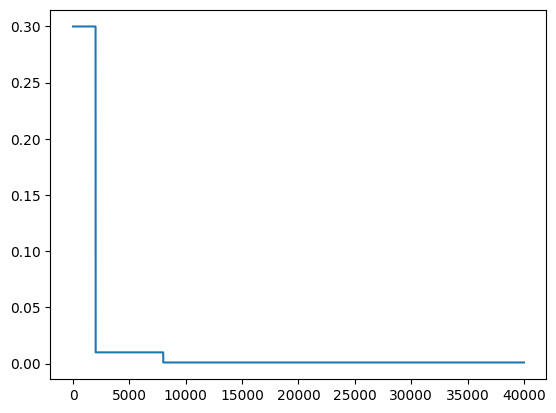

In [18]:
# Shows how the learning rate decreased over time
plt.plot(som_model_simple.learning_rate_history)

With 2D data we can make a very useful plot to determine how well the SOM has learned the data. We can plot the data points and overlay the SOM neurons from the weight cube! Ideally most of the nerons fall in one of the clusters.

Text(0.5, 1.0, 'SOM weights')

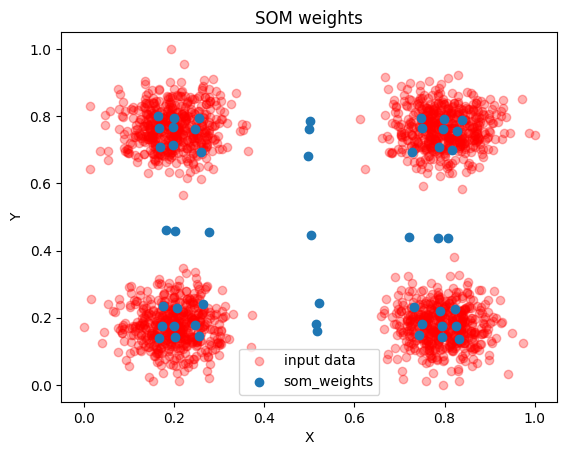

In [19]:
plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = 'som_weights')


plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title("SOM weights")

Up next we can plot the neurons in each cell. This is a useful diagnosis specially when dealing with high dimensional data as we cannot construct the plot we made above for this diminsions > 2. It shows us both how the SOM had settled and if it looks like it convereged (does it look like the cells that are close to each other look similar to their neighbors)

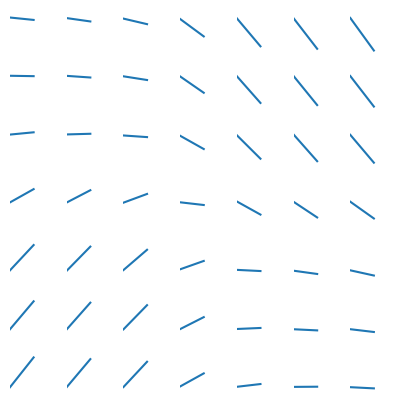

In [20]:
plot_SOM_gird_neurons(som_model_simple.weight_cube,
                              )

In [21]:
gaussian_data_4_classes_wcube = som_model_simple.weight_cube

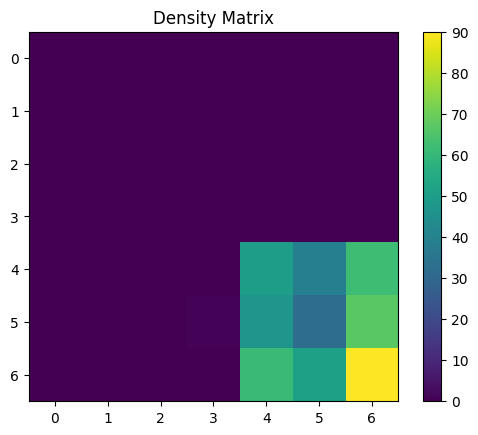

In [22]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[:500])
display_density_matrix(DENS_MAT)

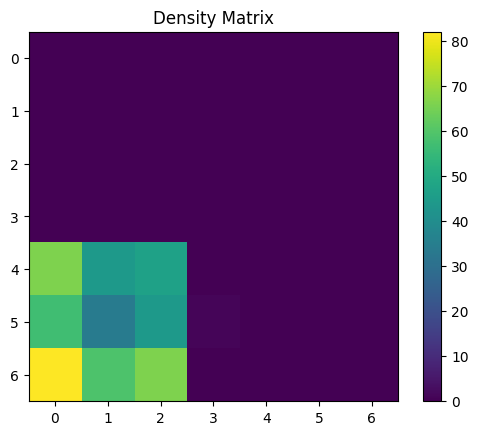

In [23]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[500:1000])
display_density_matrix(DENS_MAT)

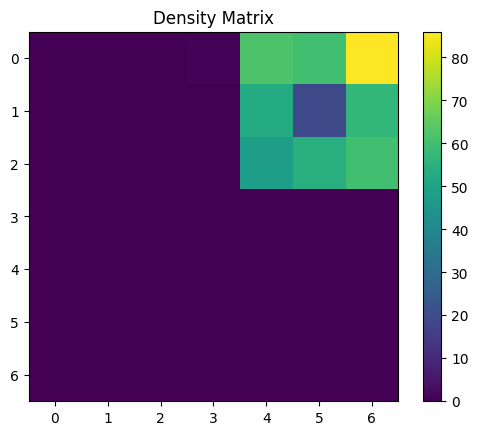

In [24]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1000:1500])
display_density_matrix(DENS_MAT)

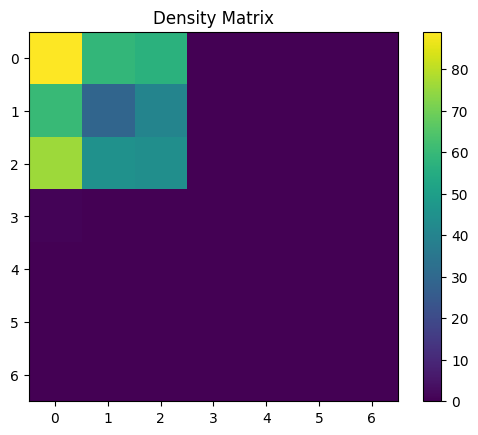

In [25]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1500:])
display_density_matrix(DENS_MAT)

In [26]:
parameters = np.zeros(1, dtype=dtype)
parameters[0] = (100, 0.7, 0.2, 3)

In [27]:
som_model = SOM(x_dim = 5, y_dim = 5, input_dim = 4, n_iter=10000,
               learning_parameters=parameters,
               decay_type='exponential', #'exponential'
               )

In [28]:
som_model.train(penguins_data_normalized)

In [29]:
wcube = som_model.weight_cube

In [30]:
som_model.learning_rate_history

array([0.7       , 0.69979003, 0.69958013, ..., 0.03488233, 0.03487186,
       0.0348614 ])

Text(0, 0.5, 'Update radius')

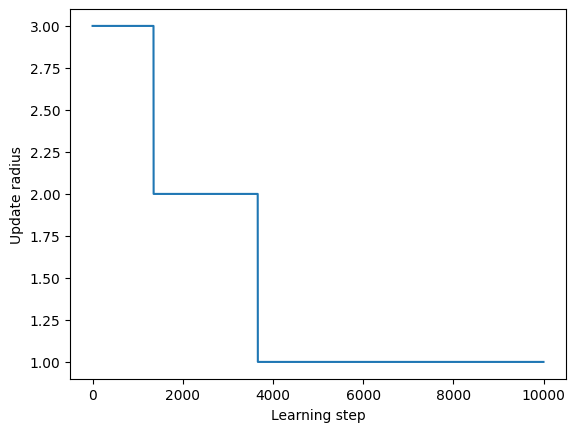

In [31]:
plt.plot(som_model.learning_radius_history)
plt.xlabel("Learning step")
plt.ylabel("Update radius")

Text(0, 0.5, 'Learning rate [alpha]')

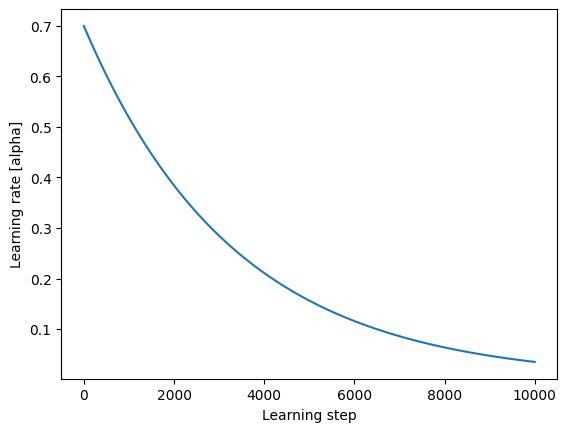

In [32]:
plt.plot(som_model.learning_rate_history)
plt.xlabel("Learning step")
plt.ylabel("Learning rate [alpha]")

Text(0, 0.5, 'Neighborhood Radius')

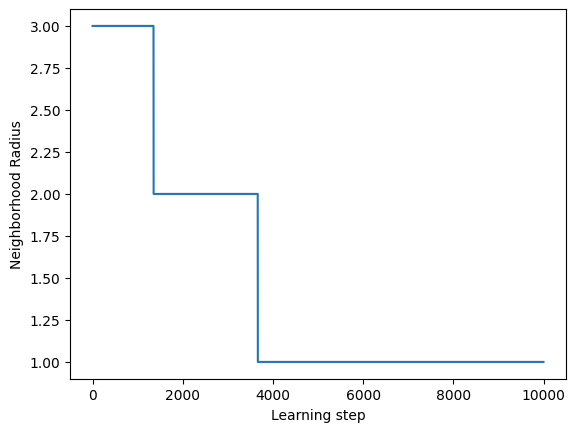

In [33]:
plt.plot(som_model.learning_radius_history)
plt.xlabel("Learning step")
plt.ylabel("Neighborhood Radius")

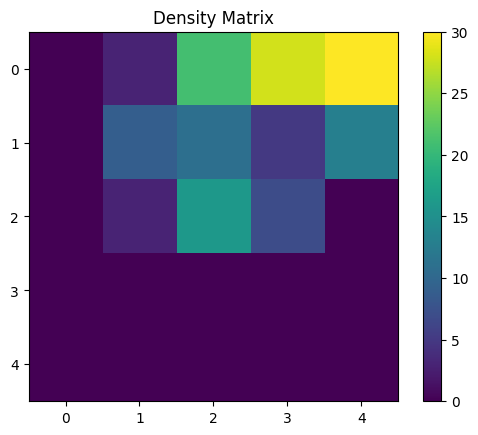

In [34]:
# Now lets test if we are getting resonable results.
#peaklet_decile = data_to_log_decile_log_area_aft_recall(peaklets_expaneded[3068176:], norm_factors)
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, penguins_data_normalized[:146])
display_density_matrix(DENS_MAT)

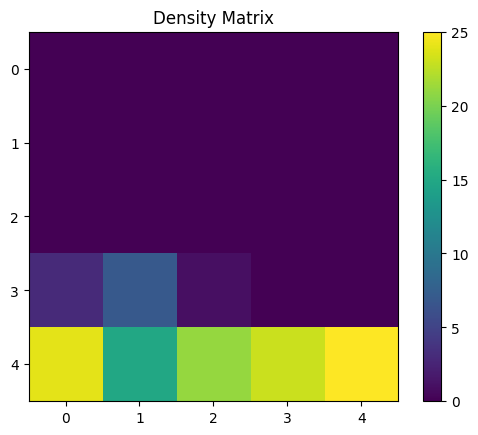

In [35]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, penguins_data_normalized[146:146+119])
display_density_matrix(DENS_MAT)

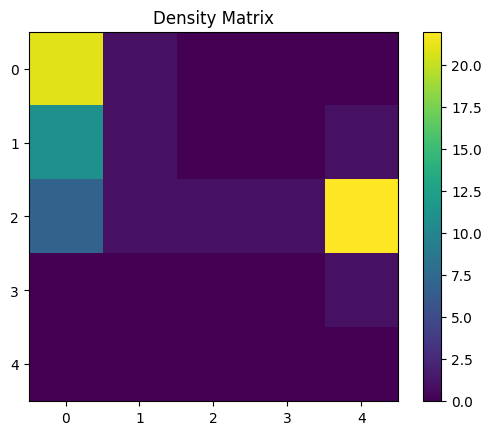

In [36]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, penguins_data_normalized[146+119:])
display_density_matrix(DENS_MAT)

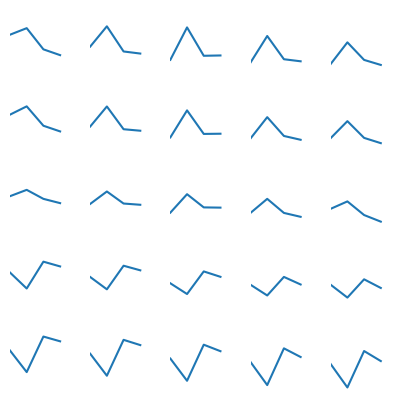

In [37]:
plot_SOM_gird_neurons(wcube,
                              )